# TCN TRY
* gemini版とgpt4版の両方でamazon株価予測してみて、結果を比較する
* 元notebook
    * /content/drive/MyDrive/study_DeepLearning/CNN_Time_Series_Forecasting/Temporal_Convolutional_Networks.ipynb

In [ ]:
!pip install darts

In [ ]:
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import Linear, Conv1d, ReLU, Dropout, MSELoss
from torch.optim import Adam
import matplotlib.pyplot as plt

In [ ]:
import torch.nn as nn

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# DownLoad Data

In [ ]:
import yfinance as yf

def extract_market_data(ticker, start_date, end_date):
    df_ohlc = yf.download(ticker, start=start_date, end=end_date)
#    df_ohlc.set_index('Date', inplace= True)
#    df_ohlc.index = pd.to_datetime(df1.index)
    return df_ohlc

# yfinance
stock1 = 'AMZN'
stock2 = 'SPY'
start_date = '2006-01-01'
end_date = '2024-06-30'

# stock
amzn = extract_market_data(stock1, start_date, end_date)
# spy = extract_market_data(stock2, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
path = '/content/drive/MyDrive/study_DeepLearning/data/'
# amzn.to_parquet(f'{path}amzn_stock.parquet')
# spy.to_parquet(f'{path}spy_stock.parquet')

amzn = pd.read_parquet(f'{path}amzn_stock.parquet')

# Preprocessing
* calc log return
* calc sma
* train test split

In [ ]:
am_c = amzn[['Close']]

# log return
am_c['log_ret'] = np.log(am_c['Close']).diff()

# sma of amzn
# am_c['sma_5'] = am_c['log_ret'].rolling(window=5).mean()
# am_c['sma_20'] = am_c['log_ret'].rolling(window=20).mean()

In [ ]:
am_c = am_c.dropna().drop(columns=['Close'])
# train_df = am_c.loc[:'2021-01-01']
train_df = am_c.loc[:'2024-01-01']
# valid_df = am_c.loc['2020-12-17':'2023-01-01'] # 前10日間はsequence_length用
test_df = am_c.loc['2023-12-15':] # 前10日間はsequence_length用

In [ ]:
am_c.loc['2023-12-15':].head(12)

,log_ret
Date,
2023-12-15,0.017150
2023-12-18,0.026972
2023-12-19,-0.001819
2023-12-20,-0.010918
2023-12-21,0.011243
2023-12-22,-0.002734
2023-12-26,-0.000065
2023-12-27,-0.000456
2023-12-28,0.000261


# Dataset Class & Data Loader

In [ ]:
class StockPriceDataset(Dataset):
    def __init__(self, df, seq_len=10):
        self.df = df
        self.seq_len = seq_len

    def __len__(self):
        return len(self.df) - self.seq_len

    def __getitem__(self, idx):
        seq = self.df.iloc[idx:idx+self.seq_len].values
        target = self.df.iloc[idx+self.seq_len]['log_ret']
        return torch.tensor(seq, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

In [ ]:
# Create dataset and dataloader
train_dataset = StockPriceDataset(train_df)
# valid_dataset = StockPriceDataset(valid_df)
test_dataset = StockPriceDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([64, 10, 1]) torch.Size([64])


* (batch_size, sequence_length, input_size)

# * TCN Model by Gemini

In [ ]:
class TCNBlock(torch.nn.Module):
    def __init__(self, input_size, n_channels, kernel_size=1, dropout=0.2):
        super(TCNBlock, self).__init__()
        pad = (kernel_size -1) * 2 # Adjust padding to maintain the same dimension after dilation
        self.conv1 = Conv1d(in_channels=input_size, out_channels=n_channels, kernel_size=kernel_size, padding=pad)
        self.relu1 = ReLU()
        self.dropout1 = Dropout(p=dropout)
        self.dilated_conv = Conv1d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=pad, dilation=2)
        self.relu2 = ReLU()
        self.dropout2 = Dropout(p=dropout)
        self.skip_conn = Conv1d(in_channels=input_size, out_channels=n_channels, kernel_size=1, padding=0)

    def forward(self, x):
        residual = self.skip_conn(x)
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.dilated_conv(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        # out += skip_conn
        # return out
        return out[:, :, :residual.size(2)] + residual # Trim out to match residual size

class TCNModel(torch.nn.Module):
    def __init__(self, input_size, n_channels, output_size, num_blocs=4, drop_out=0.2):
        super(TCNModel, self).__init__()
        self.layers = torch.nn.ModuleList()
        self.layers.append(Conv1d(in_channels=input_size, out_channels=n_channels, kernel_size=1))
        for i in range(num_blocs):
            self.layers.append(TCNBlock(n_channels, n_channels, dropout=drop_out))
        self.fc = Linear(n_channels, output_size)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = x.mean(dim=2) # Average across the sequence length dimension
        x = self.fc(x)
        return x

## * training

In [ ]:
# Hyperparameter
learining_rate = 0.001
epochs = 50
batch_size = 64
# input_size = 3
input_size = 1
n_channels = 16
output_size = 1
sequence_length = 10

# Model
model = TCNModel(input_size, n_channels, output_size)
criterion = MSELoss()
optimizer = Adam(model.parameters(), lr=learining_rate)

In [ ]:
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for features, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(features.permute(0, 2, 1)) # Change shape to (batch_size, input_size, sequence_length)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        # for features, targets in valid_loader:
        for features, targets in test_loader:
            outputs = model(features.permute(0, 2, 1))
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()

    # print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(valid_loader)}')
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(test_loader)}')

print("Training complete!")


Epoch 1/50, Train Loss: 0.0025754188073464526, Val Loss: 0.00025054532306967303
Epoch 2/50, Train Loss: 0.0007364575367447146, Val Loss: 0.0002611277304822579
Epoch 3/50, Train Loss: 0.0007382398868851941, Val Loss: 0.00025025882496265694
Epoch 4/50, Train Loss: 0.0007383368034604412, Val Loss: 0.00024360851966775954
Epoch 5/50, Train Loss: 0.0007001202050137373, Val Loss: 0.00025391351664438844
Epoch 6/50, Train Loss: 0.0006998354744520301, Val Loss: 0.00024233902513515204
Epoch 7/50, Train Loss: 0.0006793572253409878, Val Loss: 0.0002443563353153877
Epoch 8/50, Train Loss: 0.0006637661750625137, Val Loss: 0.00024168570234905928
Epoch 9/50, Train Loss: 0.0006627447007086233, Val Loss: 0.00024142201436916366
Epoch 10/50, Train Loss: 0.0006437301527115215, Val Loss: 0.00024205187219195068
Epoch 11/50, Train Loss: 0.0006470314643516297, Val Loss: 0.00024574569397373125
Epoch 12/50, Train Loss: 0.000635029685775369, Val Loss: 0.00025025606737472117
Epoch 13/50, Train Loss: 0.0006241992064

In [ ]:
# Test
model.eval()
predictions = []
targets_list = []
test_loss = 0.0
with torch.no_grad():
    for features, targets in test_loader:
        outputs = model(features.permute(0, 2, 1))
        predictions.append(outputs.numpy())
        targets_list.append(targets.numpy())
        test_loss += criterion(outputs.squeeze(), targets).item()

predictions = np.concatenate(predictions).flatten()
targets = np.concatenate(targets_list).flatten()

print(f'Test Loss: {test_loss/len(test_loader)}')

Test Loss: 0.00024150398530764505


In [ ]:
len(predictions)

124

In [ ]:
test_result_df = test_df.iloc[-124:]
test_result_df['gemini_predictions'] = predictions
test_result_df['targets'] = targets

close_df = amzn.loc['2023-12-29':, ['Close']]
close_df = close_df.join(test_result_df[['gemini_predictions', 'targets']])
close_df['predicted_close'] = np.exp(np.log(close_df['Close'].iloc[0]) + close_df['gemini_predictions'].cumsum())


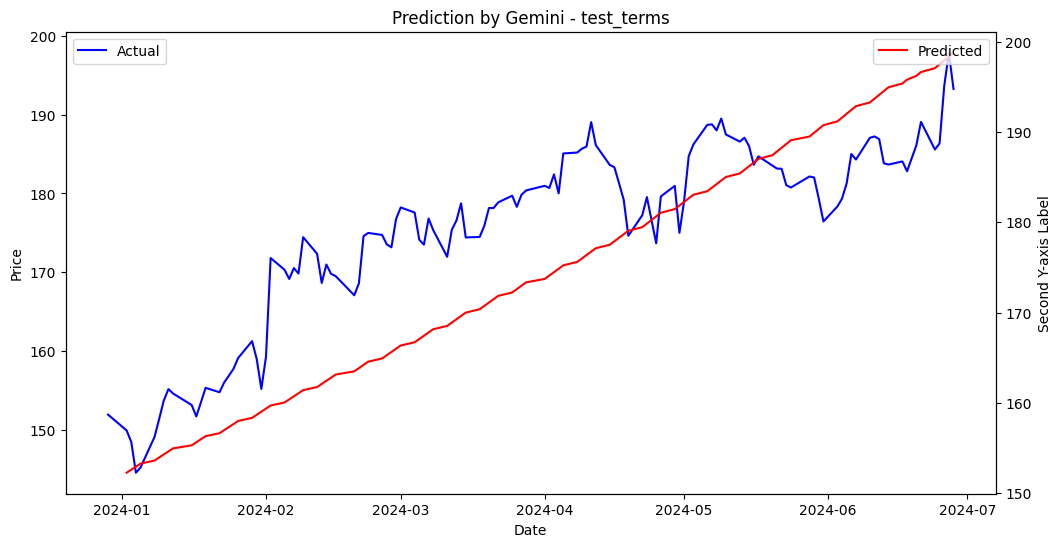

In [ ]:
# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot on the first y-axis
ax1.plot(close_df.index, close_df['Close'], label='Actual', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend(loc='upper left')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Second Y-axis Label')  # e.g., 'Volume', 'Temperature', etc.
ax2.plot(close_df.index, close_df['predicted_close'], label='Predicted', color='r')
ax2.legend(loc='upper right')

# Add title and show the plot
plt.title('Prediction by Gemini - test_terms')
plt.show()


## * train, val, test版のtest

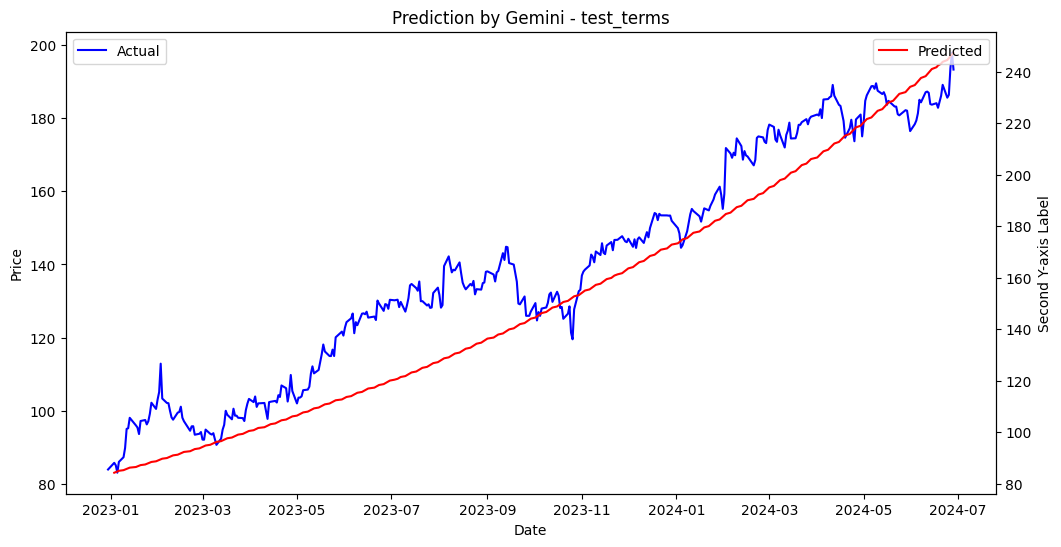

In [ ]:
# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot on the first y-axis
ax1.plot(close_df.index, close_df['Close'], label='Actual', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend(loc='upper left')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Second Y-axis Label')  # e.g., 'Volume', 'Temperature', etc.
ax2.plot(close_df.index, close_df['predicted_close'], label='Predicted', color='r')
ax2.legend(loc='upper right')

# Add title and show the plot
plt.title('Prediction by Gemini - test_terms')
plt.show()


## * trainの結果

In [ ]:
model.eval()
train_predictions = []
targets_list = []
test_loss = 0.0
with torch.no_grad():
    for features, targets in train_loader:
        outputs = model(features.permute(0, 2, 1))
        train_predictions.append(outputs.numpy())

train_predictions = np.concatenate(train_predictions).flatten()

In [ ]:
# model.eval()
# val_predictions = []
# targets_list = []
# test_loss = 0.0
# with torch.no_grad():
#     for features, targets in valid_loader:
#         outputs = model(features.permute(0, 2, 1))
#         val_predictions.append(outputs.numpy())

# val_predictions = np.concatenate(val_predictions).flatten()

In [ ]:
len(train_predictions)

4518

In [ ]:
# train_plot = train_df.iloc[-3746:]
train_plot = train_df.iloc[-4518:]
train_plot['gemini_predictions'] = train_predictions
train_plot = train_plot[['gemini_predictions']]
# close_train_pled = amzn.loc[: '2020-12-31', ['Close']]
close_train_pled = amzn.loc[: '2024-01-01', ['Close']]
close_train_pled = close_train_pled.join(train_plot)

In [ ]:
close_train_pled = close_train_pled.loc['2006-02-14':]
close_train_pled.head()

close_train_pled['close_predictions'] = np.exp(np.log(close_train_pled['Close'].iloc[0]) + close_train_pled['gemini_predictions'].cumsum())

In [ ]:
close_train_pled

,Close,gemini_predictions,close_predictions
Date,,,
2006-02-14,1.912500,0.002217,1.916745
2006-02-15,1.963000,0.002158,1.920886
2006-02-16,1.957500,0.002284,1.925279
2006-02-17,1.959500,0.002239,1.929596
2006-02-21,1.914500,0.002155,1.933757
...,...,...,...
2023-12-22,153.419998,0.002201,33327.648438
2023-12-26,153.410004,0.002230,33402.105469
2023-12-27,153.339996,0.002196,33475.515625


In [ ]:
# close_train_pled = close_train_pled.join(train_df[['log_ret']])
# close_train_pled['rev_close'] = np.exp(np.log(close_train_pled['Close'].iloc[0]) + close_train_pled['log_ret'].cumsum())

In [ ]:
# valid_plot = valid_df.iloc[-503:]
# valid_plot['gemini_predictions'] = val_predictions
# valid_plot = valid_plot[['gemini_predictions']]

In [ ]:
# close_val_pled = amzn.loc['2020-12-31': '2023-01-01', ['Close']]
# close_val_pled = close_val_pled.join(valid_plot)
# close_val_pled['close_predictions'] = np.exp(np.log(close_val_pled['Close'].iloc[0]) + close_val_pled['gemini_predictions'].cumsum())


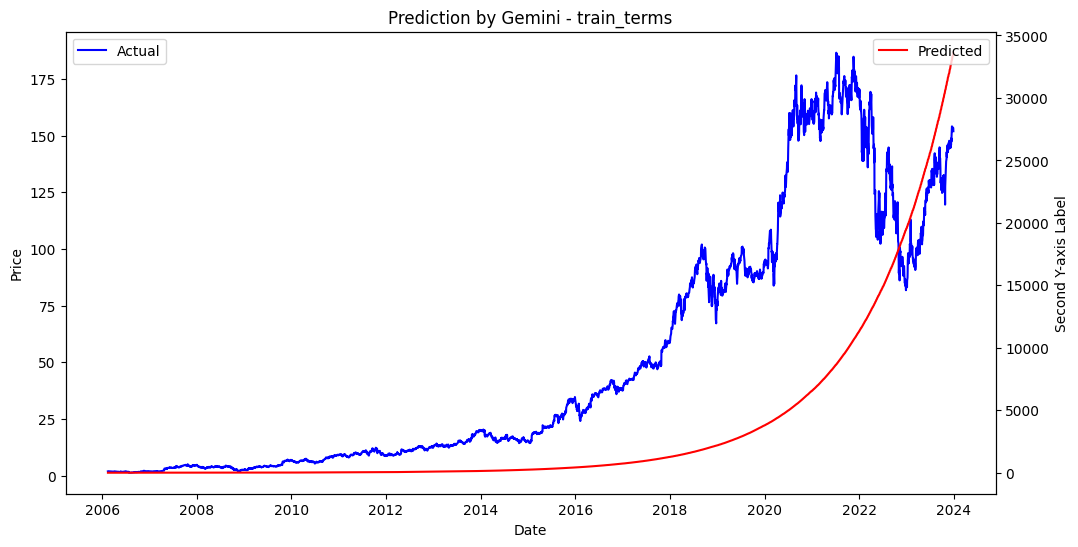

In [ ]:
# Assuming close_train_pled is a DataFrame with 'Close' and 'close_predictions' columns
# And 'some_other_column' is the column you want to plot on the second y-axis

# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot on the first y-axis
ax1.plot(close_train_pled.index, close_train_pled['Close'], label='Actual', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend(loc='upper left')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Second Y-axis Label')  # e.g., 'Volume', 'Temperature', etc.
ax2.plot(close_train_pled.index, close_train_pled['close_predictions'], label='Predicted', color='r')
ax2.legend(loc='upper right')

# Add title and show the plot
plt.title('Prediction by Gemini - train_terms')
plt.show()


## * 以下は、train, val, testに分けたときの結果

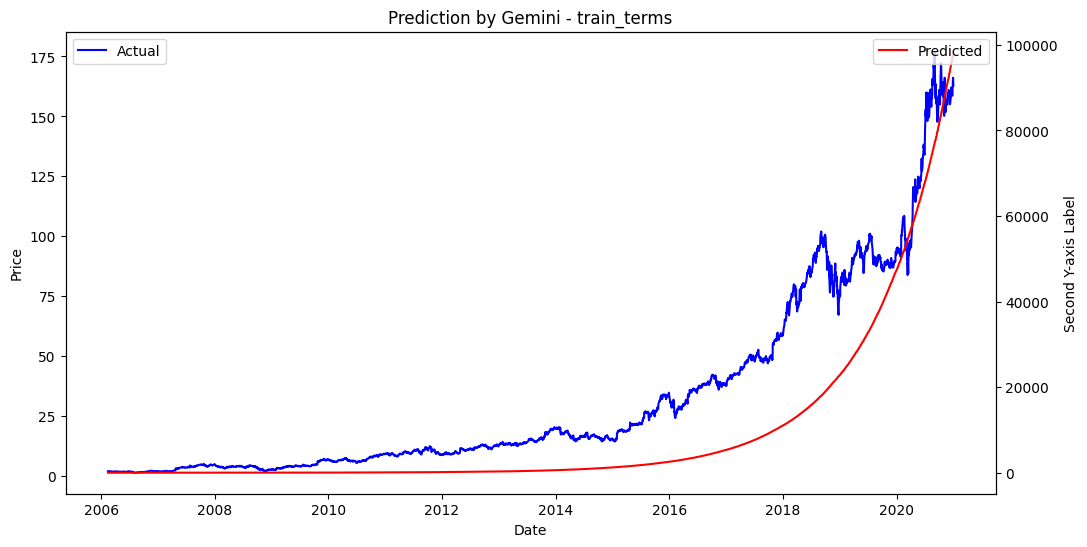

In [ ]:
# Assuming close_train_pled is a DataFrame with 'Close' and 'close_predictions' columns
# And 'some_other_column' is the column you want to plot on the second y-axis

# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot on the first y-axis
ax1.plot(close_train_pled.index, close_train_pled['Close'], label='Actual', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend(loc='upper left')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Second Y-axis Label')  # e.g., 'Volume', 'Temperature', etc.
ax2.plot(close_train_pled.index, close_train_pled['close_predictions'], label='Predicted', color='r')
ax2.legend(loc='upper right')

# Add title and show the plot
plt.title('Prediction by Gemini - train_terms')
plt.show()


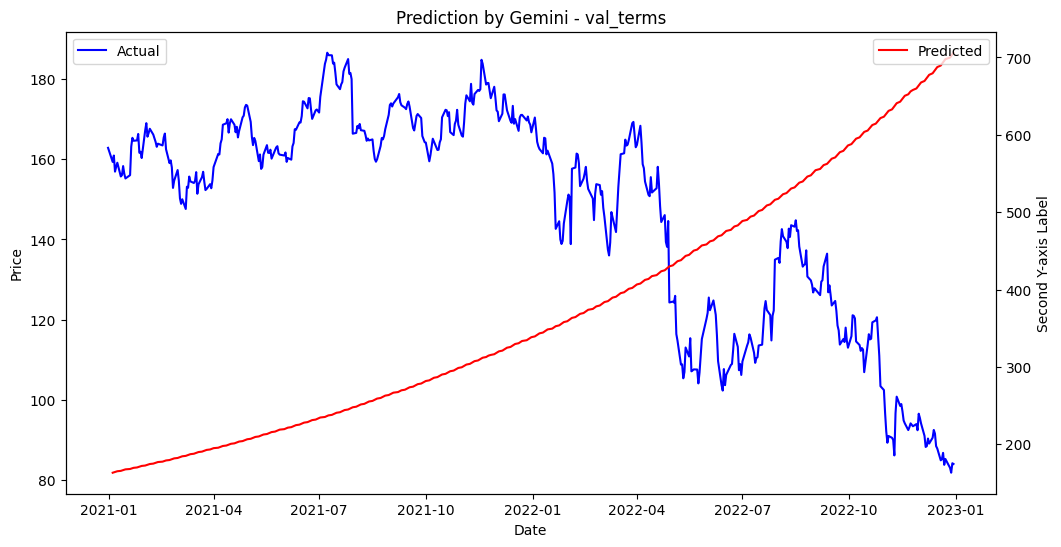

In [ ]:
# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot on the first y-axis
ax1.plot(close_val_pled.index, close_val_pled['Close'], label='Actual', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend(loc='upper left')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Second Y-axis Label')  # e.g., 'Volume', 'Temperature', etc.
ax2.plot(close_val_pled.index, close_val_pled['close_predictions'], label='Predicted', color='r')
ax2.legend(loc='upper right')

# Add title and show the plot
plt.title('Prediction by Gemini - val_terms')
plt.show()


In [ ]:
# 結果保存
close_df.to_parquet(f'{path}gemini_result.parquet')

 # * TCNModel by gpt4

In [ ]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.conv2, self.chomp2, self.relu2)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1,
                                     dilation=dilation_size, padding=(kernel_size-1)*dilation_size)]
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class TCNModel(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TCNModel, self).__init__()
        self.tcn = TemporalConvNet(num_inputs, num_channels, kernel_size, dropout)
        self.linear = nn.Linear(num_channels[-1], 1)

    def forward(self, x):
        y1 = self.tcn(x)
        y2 = self.linear(y1[:, :, -1])
        # return y1
        return y2

num_inputs = 1
num_channels = [25, 25, 25, 25]
model = TCNModel(num_inputs, num_channels)
print(model)

TCNModel(
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(1, 25, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (conv2): Conv1d(25, 25, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (net): Sequential(
          (0): Conv1d(1, 25, kernel_size=(2,), stride=(1,), padding=(1,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Conv1d(25, 25, kernel_size=(2,), stride=(1,), padding=(1,))
          (4): Chomp1d()
          (5): ReLU()
        )
        (downsample): Conv1d(1, 25, kernel_size=(1,), stride=(1,))
        (relu): ReLU()
      )
      (1): TemporalBlock(
        (conv1): Conv1d(25, 25, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (conv2): Conv1d(25, 25, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
        (chomp

## training

In [ ]:
# Hyperparameters
epochs = 50
learning_rate = 0.001

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for features, targets in train_loader:
        features = features.permute(0, 2, 1)  # Change shape to (batch_size, num_inputs, sequence_length)

        # Forward pass
        outputs = model(features).squeeze()
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        # for features, targets in valid_loader:
        for features, targets in test_loader:
            outputs = model(features.permute(0, 2, 1))
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()

    # print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(valid_loader)}')
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(test_loader)}')

print("Training complete!")

Epoch 1/50, Train Loss: 0.004656488572667077, Val Loss: 0.00026965759752783924
Epoch 2/50, Train Loss: 0.0006160890055544884, Val Loss: 0.00024947273050202057
Epoch 3/50, Train Loss: 0.000602922116202945, Val Loss: 0.00024265545653179288
Epoch 4/50, Train Loss: 0.0005902673230952465, Val Loss: 0.0002336999459657818
Epoch 5/50, Train Loss: 0.0005969452019125014, Val Loss: 0.00023610440985066816
Epoch 6/50, Train Loss: 0.0005852885951753706, Val Loss: 0.00023452428285963833
Epoch 7/50, Train Loss: 0.0005826649877478854, Val Loss: 0.00026325005455873907
Epoch 8/50, Train Loss: 0.0005887497415680858, Val Loss: 0.00025244615972042084
Epoch 9/50, Train Loss: 0.0005928443512767816, Val Loss: 0.00023998569668037817
Epoch 10/50, Train Loss: 0.0005847173425267306, Val Loss: 0.00023752291599521413
Epoch 11/50, Train Loss: 0.0005865650166245834, Val Loss: 0.00023810984566807747
Epoch 12/50, Train Loss: 0.0005907025967042525, Val Loss: 0.0002544174203649163
Epoch 13/50, Train Loss: 0.00058612477056

In [ ]:
# Test
model.eval()
predictions = []
targets_list = []
test_loss = 0.0
with torch.no_grad():
    for features, targets in test_loader:
        outputs = model(features.permute(0, 2, 1))
        predictions.append(outputs.numpy())
        targets_list.append(targets.numpy())
        test_loss += criterion(outputs.squeeze(), targets).item()

predictions = np.concatenate(predictions).flatten()
targets = np.concatenate(targets_list).flatten()

print(f'Test Loss: {test_loss/len(test_loader)}')

Test Loss: 0.0002535078820073977


In [ ]:
len(predictions)

124

In [ ]:
test_result_df = test_df.iloc[-124:]
test_result_df['gemini_predictions'] = predictions
test_result_df['targets'] = targets

close_df = amzn.loc['2023-12-29':, ['Close']]
close_df = close_df.join(test_result_df[['gemini_predictions', 'targets']])
close_df['predicted_close'] = np.exp(np.log(close_df['Close'].iloc[0]) + close_df['gemini_predictions'].cumsum())


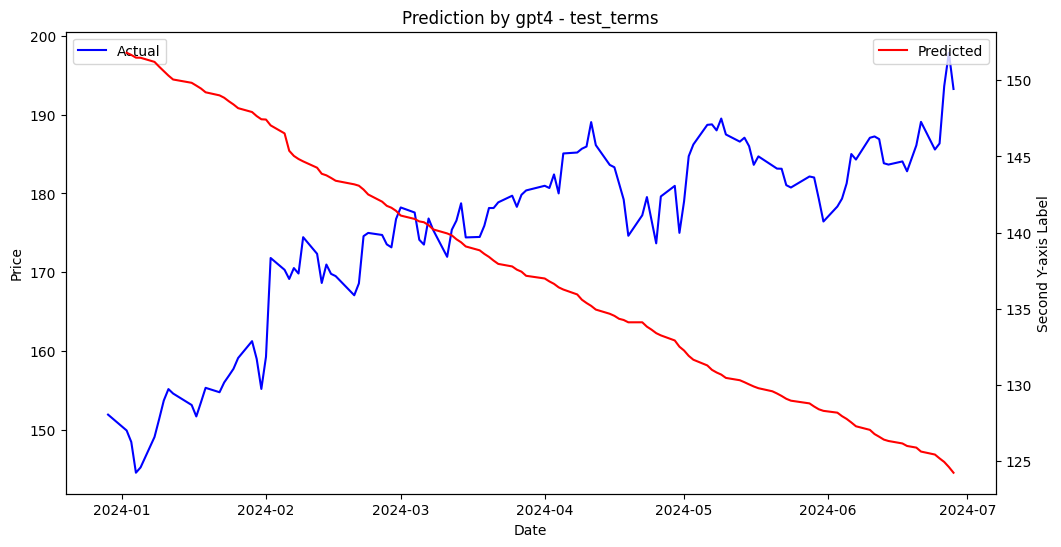

In [ ]:
# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot on the first y-axis
ax1.plot(close_df.index, close_df['Close'], label='Actual', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend(loc='upper left')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Second Y-axis Label')  # e.g., 'Volume', 'Temperature', etc.
ax2.plot(close_df.index, close_df['predicted_close'], label='Predicted', color='r')
ax2.legend(loc='upper right')

# Add title and show the plot
plt.title('Prediction by gpt4 - test_terms')
plt.show()


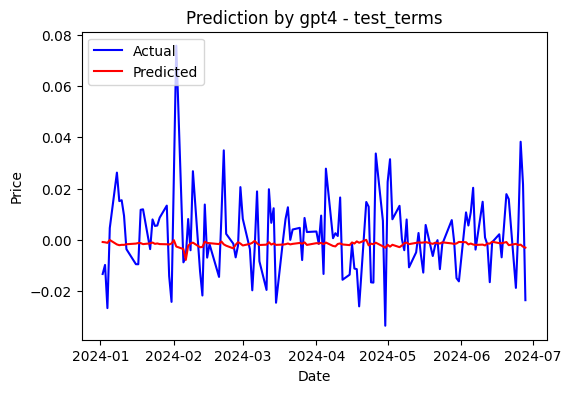

In [ ]:
test_result_df

# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(6, 4))

# Plot on the first y-axis
ax1.plot(test_result_df.index, test_result_df['targets'], label='Actual', color='b')
ax1.plot(test_result_df.index, test_result_df['gemini_predictions'], label='Predicted', color='r')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend(loc='upper left')

# Add title and show the plot
plt.title('Prediction by gpt4 - test_terms')
plt.show()


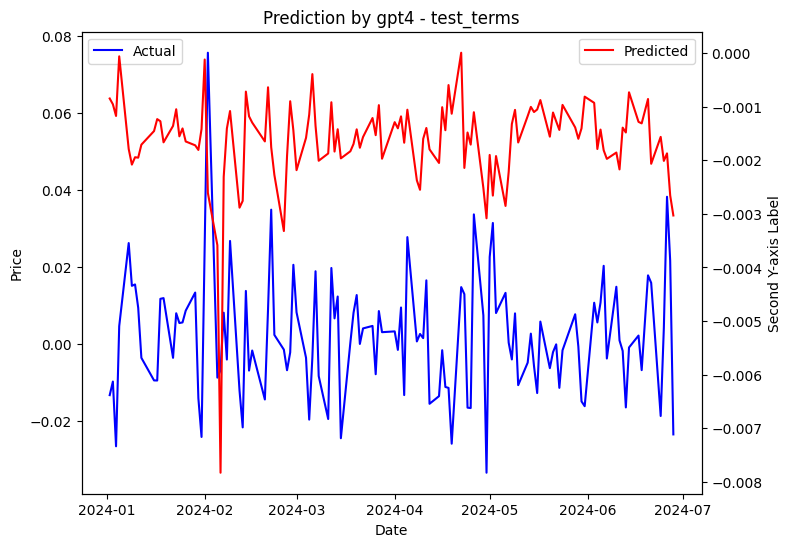

In [ ]:
# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot on the first y-axis
ax1.plot(test_result_df.index, test_result_df['targets'], label='Actual', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend(loc='upper left')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Second Y-axis Label')  # e.g., 'Volume', 'Temperature', etc.
ax2.plot(test_result_df.index, test_result_df['gemini_predictions'], label='Predicted', color='r')
ax2.legend(loc='upper right')

# Add title and show the plot
plt.title('Prediction by gpt4 - test_terms')
plt.show()


In [ ]:
test_result_df.drop(columns=['log_ret']).corr()

,gemini_predictions,targets
gemini_predictions,1.000000,0.048009
targets,0.048009,1.000000


## trainの結果

In [ ]:
model.eval()
train_predictions = []
targets_list = []
test_loss = 0.0
with torch.no_grad():
    for features, targets in train_loader:
        outputs = model(features.permute(0, 2, 1))
        train_predictions.append(outputs.numpy())

train_predictions = np.concatenate(train_predictions).flatten()

In [ ]:
len(train_predictions)

4518

In [ ]:
# train_plot = train_df.iloc[-3746:]
train_plot = train_df.iloc[-4518:]
train_plot['gemini_predictions'] = train_predictions
train_plot = train_plot[['gemini_predictions']]
# close_train_pled = amzn.loc[: '2020-12-31', ['Close']]
close_train_pled = amzn.loc[: '2024-01-01', ['Close']]
close_train_pled = close_train_pled.join(train_plot)

In [ ]:
close_train_pled = close_train_pled.loc['2006-02-14':]
close_train_pled.head()

close_train_pled['close_predictions'] = np.exp(np.log(close_train_pled['Close'].iloc[0]) + close_train_pled['gemini_predictions'].cumsum())

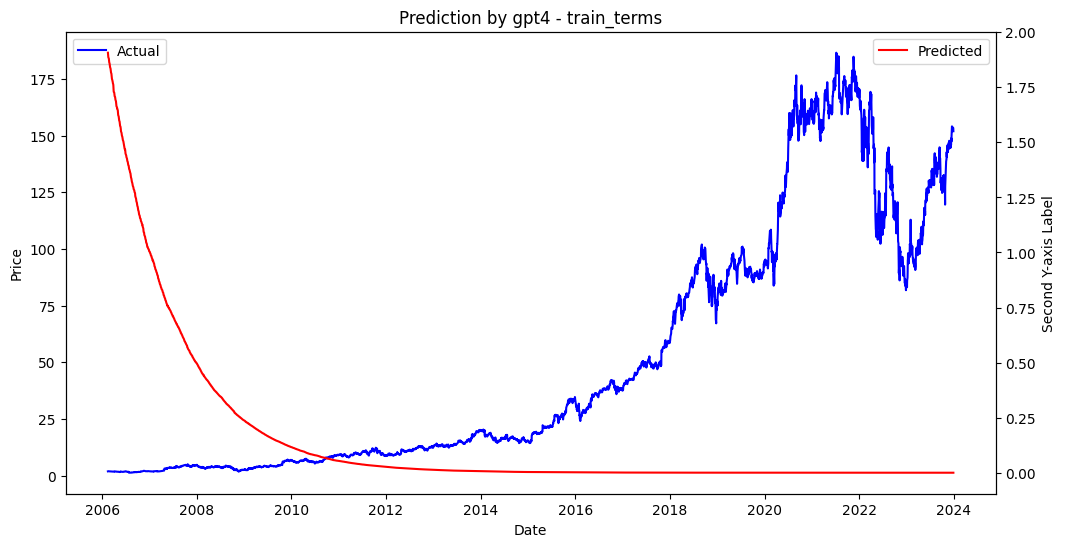

In [ ]:
# Assuming close_train_pled is a DataFrame with 'Close' and 'close_predictions' columns
# And 'some_other_column' is the column you want to plot on the second y-axis

# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot on the first y-axis
ax1.plot(close_train_pled.index, close_train_pled['Close'], label='Actual', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend(loc='upper left')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Second Y-axis Label')  # e.g., 'Volume', 'Temperature', etc.
ax2.plot(close_train_pled.index, close_train_pled['close_predictions'], label='Predicted', color='r')
ax2.legend(loc='upper right')

# Add title and show the plot
plt.title('Prediction by gpt4 - train_terms')
plt.show()


# * Simplest TCNModel

In [ ]:
# Define the TCN model
class TCN(torch.nn.Module):
    def __init__(self, input_size=1, num_channels=16, output_size=1, kernel_size=2, dropout=0.2):
        super(TCN, self).__init__()
        self.tcn = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=input_size, out_channels=num_channels, kernel_size=kernel_size, padding=(kernel_size-1), dilation=1),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=dropout),
            torch.nn.Conv1d(in_channels=num_channels, out_channels=output_size, kernel_size=kernel_size, padding=(kernel_size-1), dilation=2),
            torch.nn.ReLU(),
        )

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.tcn(x)
        return x[:, :, -1] # Return the last output for prediction

In [ ]:
# Hyperparameter
learining_rate = 0.001
epochs = 50
batch_size = 64
# input_size = 3
input_size = 1
n_channels = 16
output_size = 1
sequence_length = 10

# Model
model = TCN(input_size, n_channels, output_size)
criterion = MSELoss()
optimizer = Adam(model.parameters(), lr=learining_rate)

In [ ]:
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for features, targets in train_loader:
        optimizer.zero_grad()
        # outputs = model(features.permute(0, 2, 1)) # Change shape to (batch_size, input_size, sequence_length)
        outputs = model(features)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        # for features, targets in valid_loader:
        for features, targets in test_loader:
            # outputs = model(features.permute(0, 2, 1))
            outputs = model(features)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()

    # print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(valid_loader)}')
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(test_loader)}')

print("Training complete!")


Epoch 1/50, Train Loss: 0.0030737830482547917, Val Loss: 0.00024519088765373453
Epoch 2/50, Train Loss: 0.000743307506101547, Val Loss: 0.00024519088765373453
Epoch 3/50, Train Loss: 0.0006647117617933578, Val Loss: 0.00024519088765373453
Epoch 4/50, Train Loss: 0.0006214791837535327, Val Loss: 0.00024519088765373453
Epoch 5/50, Train Loss: 0.0006232421790269321, Val Loss: 0.00024519088765373453
Epoch 6/50, Train Loss: 0.000604048755813495, Val Loss: 0.00024519088765373453
Epoch 7/50, Train Loss: 0.0005943720925002503, Val Loss: 0.00024519088765373453
Epoch 8/50, Train Loss: 0.0005959959194051023, Val Loss: 0.00024519088765373453
Epoch 9/50, Train Loss: 0.0005949830011674531, Val Loss: 0.00024519088765373453
Epoch 10/50, Train Loss: 0.0005922615499412773, Val Loss: 0.00024519088765373453
Epoch 11/50, Train Loss: 0.00058673909585759, Val Loss: 0.00024519088765373453
Epoch 12/50, Train Loss: 0.0005913654450510799, Val Loss: 0.00024519088765373453
Epoch 13/50, Train Loss: 0.00058525558077

In [ ]:
# for features, targets in test_loader:
#     outputs = model(features.permute(0, 2, 1))
#     break

for features, targets in test_loader:
    print(features.shape)
    break

torch.Size([64, 10, 1])


In [ ]:
# Test
model.eval()
predictions = []
targets_list = []
test_loss = 0.0
with torch.no_grad():
    for features, targets in test_loader:
        # outputs = model(features.permute(0, 2, 1))
        outputs = model(features)
        predictions.append(outputs.numpy())
        targets_list.append(targets.numpy())
        test_loss += criterion(outputs.squeeze(), targets).item()

predictions = np.concatenate(predictions).flatten()
targets = np.concatenate(targets_list).flatten()

print(f'Test Loss: {test_loss/len(test_loader)}')

Test Loss: 0.00024519088765373453


In [ ]:
test_result_df = test_df.iloc[-124:]
test_result_df['gemini_predictions'] = predictions
test_result_df['targets'] = targets

close_df = amzn.loc['2023-12-29':, ['Close']]
close_df = close_df.join(test_result_df[['gemini_predictions', 'targets']])
close_df['predicted_close'] = np.exp(np.log(close_df['Close'].iloc[0]) + close_df['gemini_predictions'].cumsum())


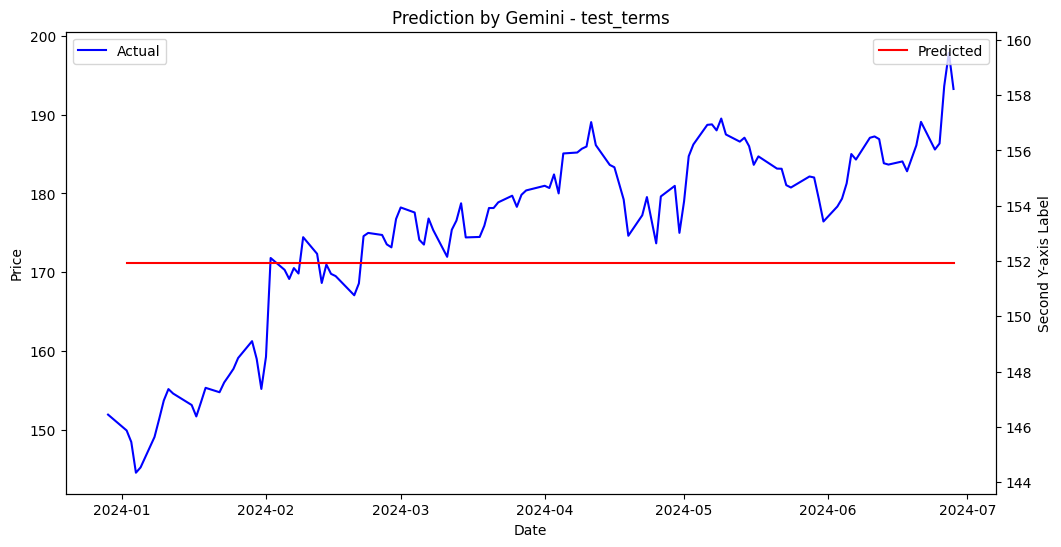

In [ ]:
# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot on the first y-axis
ax1.plot(close_df.index, close_df['Close'], label='Actual', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend(loc='upper left')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Second Y-axis Label')  # e.g., 'Volume', 'Temperature', etc.
ax2.plot(close_df.index, close_df['predicted_close'], label='Predicted', color='r')
ax2.legend(loc='upper right')

# Add title and show the plot
plt.title('Prediction by Gemini - test_terms')
plt.show()


## *  trainの結果

In [ ]:
model.eval()
train_predictions = []
targets_list = []
test_loss = 0.0
with torch.no_grad():
    for features, targets in train_loader:
        # outputs = model(features.permute(0, 2, 1))
        outputs = model(features)
        train_predictions.append(outputs.numpy())

train_predictions = np.concatenate(train_predictions).flatten()

In [ ]:
close_train_pled = close_train_pled.loc['2006-02-14':]
close_train_pled.head()

close_train_pled['close_predictions'] = np.exp(np.log(close_train_pled['Close'].iloc[0]) + close_train_pled['gemini_predictions'].cumsum())

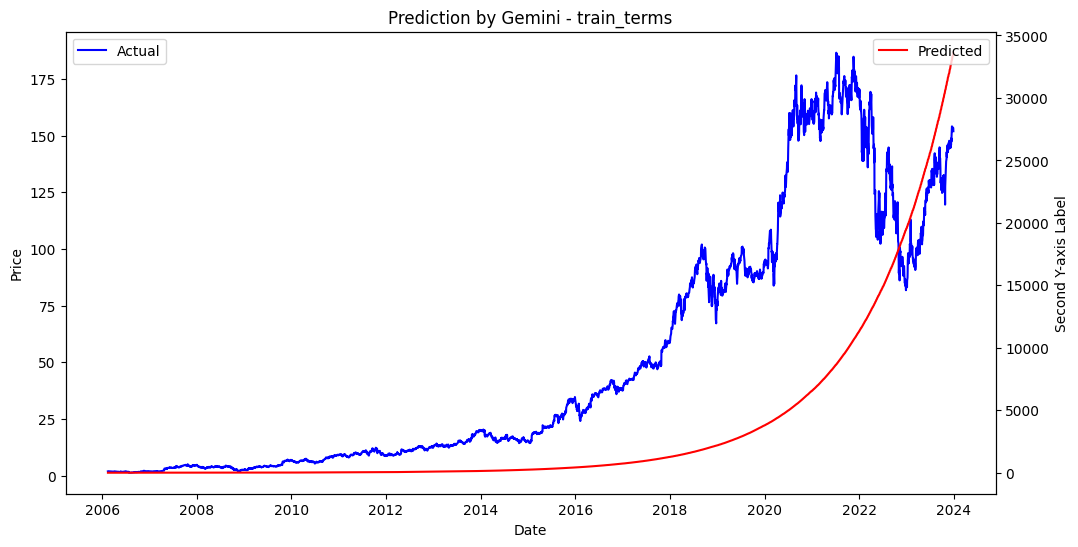

In [ ]:
# Assuming close_train_pled is a DataFrame with 'Close' and 'close_predictions' columns
# And 'some_other_column' is the column you want to plot on the second y-axis

# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot on the first y-axis
ax1.plot(close_train_pled.index, close_train_pled['Close'], label='Actual', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend(loc='upper left')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Second Y-axis Label')  # e.g., 'Volume', 'Temperature', etc.
ax2.plot(close_train_pled.index, close_train_pled['close_predictions'], label='Predicted', color='r')
ax2.legend(loc='upper right')

# Add title and show the plot
plt.title('Prediction by Gemini - train_terms')
plt.show()


# Model by YouTube
* https://www.kaggle.com/code/jeffheaton/ds-beach-demand-naive-forecast/notebook

In [ ]:
class TCNModel(nn.Module):
    def __init__(self):
        super(TCNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=8)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64, 50)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
# Hyperparameter
learining_rate = 0.001
epochs = 50
# batch_size = 64
# # input_size = 3
# input_size = 1
# n_channels = 16
# output_size = 1
# sequence_length = 10

# Model
model = TCNModel()
criterion = MSELoss()
optimizer = Adam(model.parameters(), lr=learining_rate)

In [ ]:
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for features, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(features.permute(0, 2, 1)) # Change shape to (batch_size, input_size, sequence_length)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        # for features, targets in valid_loader:
        for features, targets in test_loader:
            outputs = model(features.permute(0, 2, 1))
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()

    # print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(valid_loader)}')
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(test_loader)}')

print("Training complete!")


Epoch 1/50, Train Loss: 0.0009477177075713768, Val Loss: 0.0002600086882011965
Epoch 2/50, Train Loss: 0.0006512472029729471, Val Loss: 0.0002572916855569929
Epoch 3/50, Train Loss: 0.0006136384679489887, Val Loss: 0.000247720381594263
Epoch 4/50, Train Loss: 0.0005972152727518336, Val Loss: 0.00025069107505260035
Epoch 5/50, Train Loss: 0.0005895043715086936, Val Loss: 0.0002488014579284936
Epoch 6/50, Train Loss: 0.0005888139499469437, Val Loss: 0.00024267694971058518
Epoch 7/50, Train Loss: 0.0005850582141724323, Val Loss: 0.00024304178077727556
Epoch 8/50, Train Loss: 0.0005789515066360661, Val Loss: 0.00024762708926573396
Epoch 9/50, Train Loss: 0.0005829555636704702, Val Loss: 0.00024196520098485053
Epoch 10/50, Train Loss: 0.000580929470179655, Val Loss: 0.0002598807477625087
Epoch 11/50, Train Loss: 0.0005815545526172467, Val Loss: 0.0002419970915070735
Epoch 12/50, Train Loss: 0.0005800275762916319, Val Loss: 0.0002416466668364592
Epoch 13/50, Train Loss: 0.0005764368705084206

In [ ]:
# Test
model.eval()
predictions = []
targets_list = []
test_loss = 0.0
with torch.no_grad():
    for features, targets in test_loader:
        outputs = model(features.permute(0, 2, 1))
        predictions.append(outputs.numpy())
        targets_list.append(targets.numpy())
        test_loss += criterion(outputs.squeeze(), targets).item()

predictions = np.concatenate(predictions).flatten()
targets = np.concatenate(targets_list).flatten()

print(f'Test Loss: {test_loss/len(test_loader)}')

Test Loss: 0.0002458362141624093


In [ ]:
len(predictions)

124

In [ ]:
test_result_df = test_df.iloc[-124:]
test_result_df['gemini_predictions'] = predictions
test_result_df['targets'] = targets

close_df = amzn.loc['2023-12-29':, ['Close']]
close_df = close_df.join(test_result_df[['gemini_predictions', 'targets']])
close_df['predicted_close'] = np.exp(np.log(close_df['Close'].iloc[0]) + close_df['gemini_predictions'].cumsum())


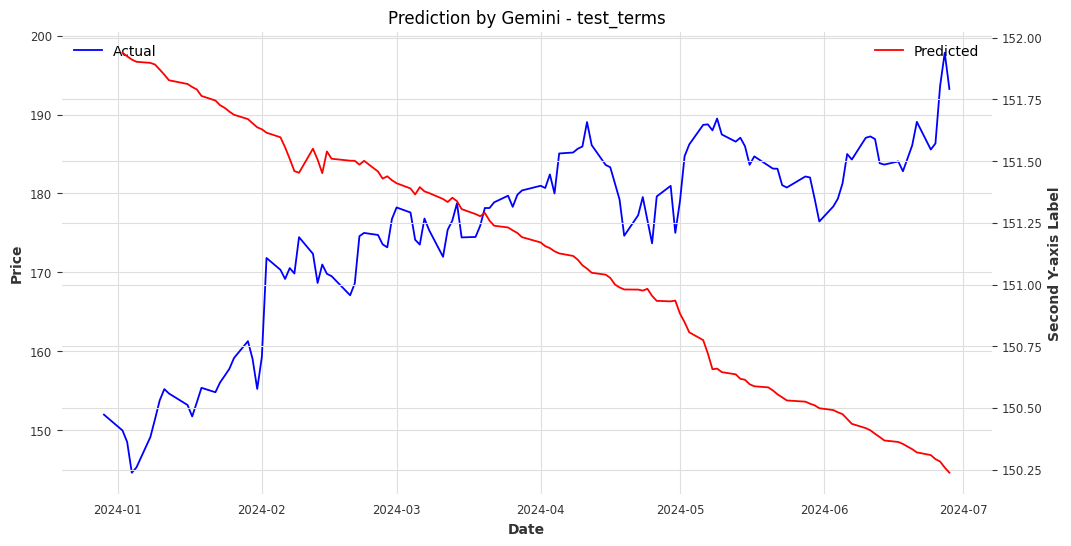

In [ ]:
# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot on the first y-axis
ax1.plot(close_df.index, close_df['Close'], label='Actual', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend(loc='upper left')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Second Y-axis Label')  # e.g., 'Volume', 'Temperature', etc.
ax2.plot(close_df.index, close_df['predicted_close'], label='Predicted', color='r')
ax2.legend(loc='upper right')

# Add title and show the plot
plt.title('Prediction by Gemini - test_terms')
plt.show()


## * trainの結果

In [ ]:
model.eval()
train_predictions = []
targets_list = []
test_loss = 0.0
with torch.no_grad():
    for features, targets in train_loader:
        outputs = model(features.permute(0, 2, 1))
        train_predictions.append(outputs.numpy())

train_predictions = np.concatenate(train_predictions).flatten()

In [ ]:
len(train_predictions)

4518

In [ ]:
# train_plot = train_df.iloc[-3746:]
train_plot = train_df.iloc[-4518:]
train_plot['gemini_predictions'] = train_predictions
train_plot = train_plot[['gemini_predictions']]
# close_train_pled = amzn.loc[: '2020-12-31', ['Close']]
close_train_pled = amzn.loc[: '2024-01-01', ['Close']]
close_train_pled = close_train_pled.join(train_plot)

In [ ]:
close_train_pled = close_train_pled.loc['2006-02-14':]
close_train_pled.head()

close_train_pled['close_predictions'] = np.exp(np.log(close_train_pled['Close'].iloc[0]) + close_train_pled['gemini_predictions'].cumsum())

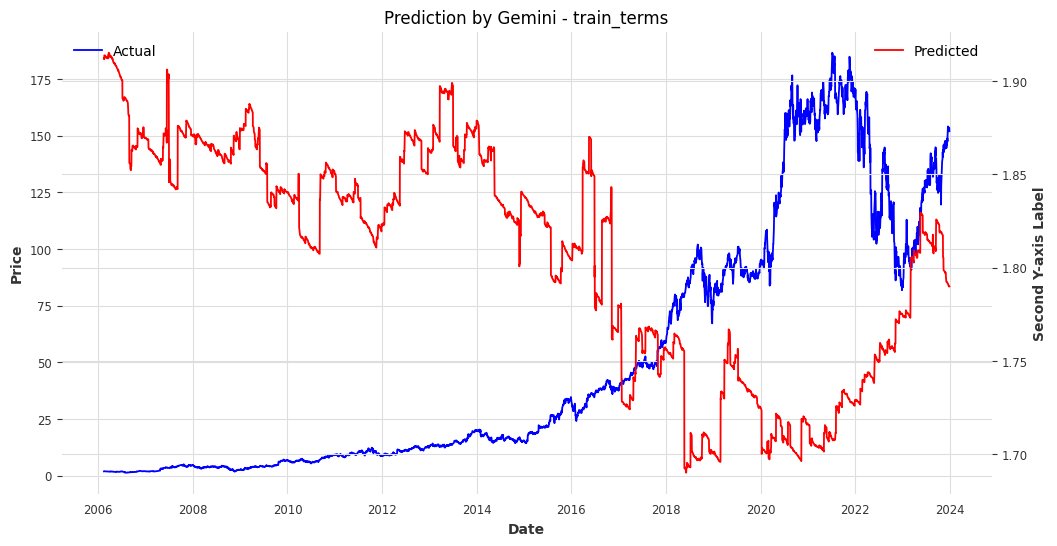

In [ ]:
# Assuming close_train_pled is a DataFrame with 'Close' and 'close_predictions' columns
# And 'some_other_column' is the column you want to plot on the second y-axis

# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot on the first y-axis
ax1.plot(close_train_pled.index, close_train_pled['Close'], label='Actual', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend(loc='upper left')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Second Y-axis Label')  # e.g., 'Volume', 'Temperature', etc.
ax2.plot(close_train_pled.index, close_train_pled['close_predictions'], label='Predicted', color='r')
ax2.legend(loc='upper right')

# Add title and show the plot
plt.title('Prediction by Gemini - train_terms')
plt.show()


# 元論文版
* https://qiita.com/ooyamatakehisa/items/2a044b41c69f3c8802ef
* https://github.com/locuslab/TCN/blob/master/TCN/tcn.py

In [132]:
from torch.nn.utils import weight_norm


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


class TCNModel(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TCNModel, self).__init__()
        self.tcn = TemporalConvNet(num_inputs, num_channels, kernel_size, dropout)
        self.linear = nn.Linear(num_channels[-1], 1)

    def forward(self, x):
        y1 = self.tcn(x)
        y2 = self.linear(y1[:, :, -1])
        # return y1
        return y2

In [133]:
# Hyperparameter
learining_rate = 0.001
epochs = 50
# batch_size = 64
input_size = 1
n_channels = [16, 32, 64]
# n_channels = 16
output_size = 1
# sequence_length = 10

# Model
model = TCNModel(num_inputs=input_size, num_channels=n_channels)
criterion = MSELoss()
optimizer = Adam(model.parameters(), lr=learining_rate)

In [136]:
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for features, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(features.permute(0, 2, 1)) # Change shape to (batch_size, input_size, sequence_length)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        # for features, targets in valid_loader:
        for features, targets in test_loader:
            outputs = model(features.permute(0, 2, 1))
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()

    # print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(valid_loader)}')
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(test_loader)}')

print("Training complete!")


Epoch 1/50, Train Loss: 0.0008652970640802048, Val Loss: 0.00024204781220760196
Epoch 2/50, Train Loss: 0.0006023706601027556, Val Loss: 0.00024241331993835047
Epoch 3/50, Train Loss: 0.0005969747882106827, Val Loss: 0.00024210406263591722
Epoch 4/50, Train Loss: 0.0005865407048832808, Val Loss: 0.00024246066459454596
Epoch 5/50, Train Loss: 0.0005858241290208215, Val Loss: 0.0002453451816109009
Epoch 6/50, Train Loss: 0.0005919863392015211, Val Loss: 0.00026227248599752784
Epoch 7/50, Train Loss: 0.0005837823469257376, Val Loss: 0.0002469250757712871
Epoch 8/50, Train Loss: 0.0005826889287227844, Val Loss: 0.000244198068685364
Epoch 9/50, Train Loss: 0.00058129677056289, Val Loss: 0.00024197240418288857
Epoch 10/50, Train Loss: 0.0005889349952372919, Val Loss: 0.00028279045363888144
Epoch 11/50, Train Loss: 0.0005806125458625054, Val Loss: 0.00024412178754573688
Epoch 12/50, Train Loss: 0.0005818613428576574, Val Loss: 0.00024488197232130915
Epoch 13/50, Train Loss: 0.0005862150057612

In [137]:
# Test
model.eval()
predictions = []
targets_list = []
test_loss = 0.0
with torch.no_grad():
    for features, targets in test_loader:
        outputs = model(features.permute(0, 2, 1))
        predictions.append(outputs.numpy())
        targets_list.append(targets.numpy())
        test_loss += criterion(outputs.squeeze(), targets).item()

predictions = np.concatenate(predictions).flatten()
targets = np.concatenate(targets_list).flatten()

print(f'Test Loss: {test_loss/len(test_loader)}')

Test Loss: 0.0002489702819730155


In [138]:
len(predictions)

124

In [139]:
test_result_df = test_df.iloc[-124:]
test_result_df['gemini_predictions'] = predictions
test_result_df['targets'] = targets

close_df = amzn.loc['2023-12-29':, ['Close']]
close_df = close_df.join(test_result_df[['gemini_predictions', 'targets']])
close_df['predicted_close'] = np.exp(np.log(close_df['Close'].iloc[0]) + close_df['gemini_predictions'].cumsum())


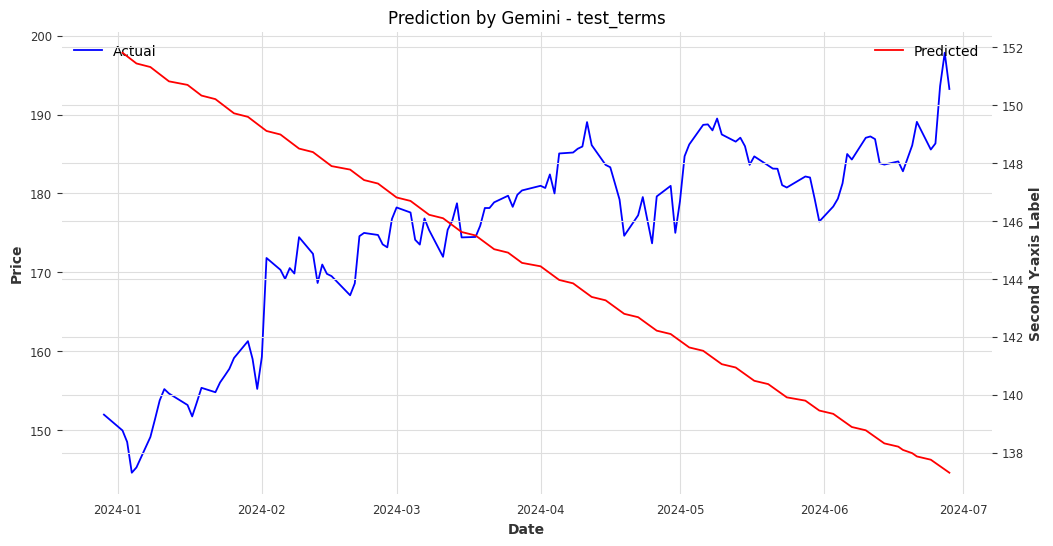

In [140]:
# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot on the first y-axis
ax1.plot(close_df.index, close_df['Close'], label='Actual', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend(loc='upper left')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Second Y-axis Label')  # e.g., 'Volume', 'Temperature', etc.
ax2.plot(close_df.index, close_df['predicted_close'], label='Predicted', color='r')
ax2.legend(loc='upper right')

# Add title and show the plot
plt.title('Prediction by Gemini - test_terms')
plt.show()


## * trainの結果

In [141]:
model.eval()
train_predictions = []
targets_list = []
test_loss = 0.0
with torch.no_grad():
    for features, targets in train_loader:
        outputs = model(features.permute(0, 2, 1))
        train_predictions.append(outputs.numpy())

train_predictions = np.concatenate(train_predictions).flatten()

In [142]:
len(train_predictions)

4518

In [143]:
# train_plot = train_df.iloc[-3746:]
train_plot = train_df.iloc[-4518:]
train_plot['gemini_predictions'] = train_predictions
train_plot = train_plot[['gemini_predictions']]
# close_train_pled = amzn.loc[: '2020-12-31', ['Close']]
close_train_pled = amzn.loc[: '2024-01-01', ['Close']]
close_train_pled = close_train_pled.join(train_plot)

In [144]:
close_train_pled = close_train_pled.loc['2006-02-14':]
close_train_pled.head()

close_train_pled['close_predictions'] = np.exp(np.log(close_train_pled['Close'].iloc[0]) + close_train_pled['gemini_predictions'].cumsum())

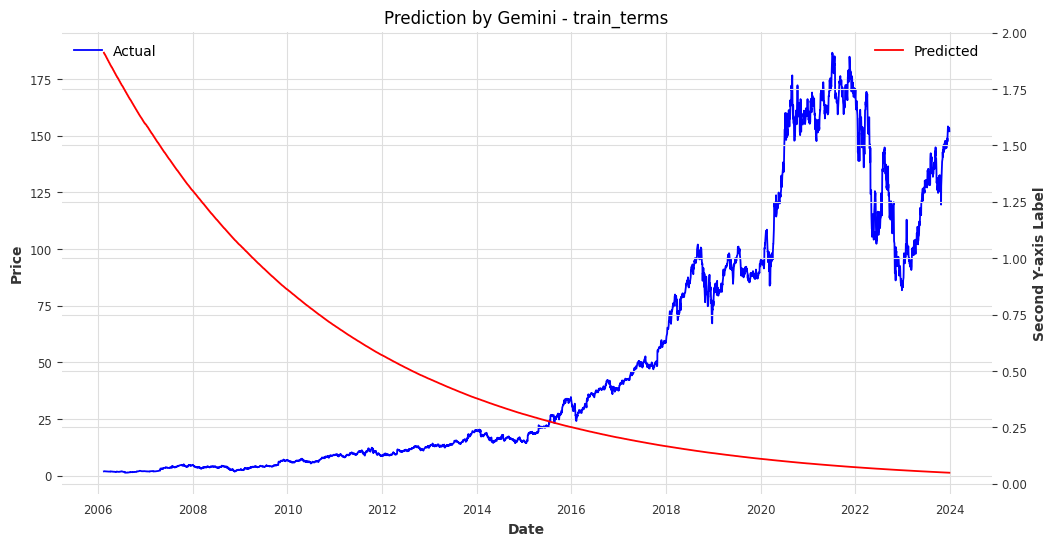

In [145]:
# Assuming close_train_pled is a DataFrame with 'Close' and 'close_predictions' columns
# And 'some_other_column' is the column you want to plot on the second y-axis

# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot on the first y-axis
ax1.plot(close_train_pled.index, close_train_pled['Close'], label='Actual', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend(loc='upper left')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Second Y-axis Label')  # e.g., 'Volume', 'Temperature', etc.
ax2.plot(close_train_pled.index, close_train_pled['close_predictions'], label='Predicted', color='r')
ax2.legend(loc='upper right')

# Add title and show the plot
plt.title('Prediction by Gemini - train_terms')
plt.show()
